In [86]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import os
import io
import re
from scipy.io.wavfile import read
from sklearn.datasets import make_blobs
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.cm as cmx
from datetime import datetime, timezone
import datetime
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from pathlib import Path
from sklearn.cluster import KMeans
import copy
from scipy.stats import mode


In [87]:
def load_waveform(filepath):
    with open(filepath) as dataFile:
        data = dataFile.read()
        # Check for missing commas and insert them
        pattern = r'(\{[^{}]*"[^"]*"[^{}]*\})(?=[^{}]*\{)'
        data = re.sub(pattern, r'\1,', data)

        obj = data[data.find('{') : data.rfind('}')+1]
        jsonObj = json.loads(obj)
        
        if jsonObj['data']:
            waveform_data = pd.DataFrame(jsonObj['data'], columns=["peak_amplitude","integral","phase_angle","cycle_number","rise_time","pulse_width"])    
            return waveform_data
    return None


In [88]:
def load_dataframes(dirpath):
    dataframes = []
    for filename in os.listdir(dirpath):
        if filename.endswith(".js"):
            filepath = os.path.join(dirpath, filename)
            waveform = load_waveform(filepath)
            if not waveform.empty:
                waveform['filename'] = filename # Add filename as a column
                dataframes.append(waveform)
    return dataframes

In [89]:
dirpath1 = "ptest"
dirpath2 = "ntest"
dirpath3 = "utest"
pdf = load_dataframes(dirpath1)
ndf = load_dataframes(dirpath2)
udf = load_dataframes(dirpath3)

In [90]:
def assign_dependent_vars(dataframes, y):
    for df in dataframes:
        df['anomaly'] = y # initialize with 0
        # assign dependent variable values based on some condition
        # df.loc[df['some_column'] > 0, 'dependent_var'] = 1
        # df.loc[df['some_column'] < 0, 'dependent_var'] = 2
    return dataframes


In [91]:
pdf = assign_dependent_vars(pdf, 1) #assign dependent variables for supervised testing
ndf = assign_dependent_vars(ndf, 2)
udf = assign_dependent_vars(udf, 0)

In [92]:
# combine all list of dataframes into 1
dataframes = pdf + ndf + udf

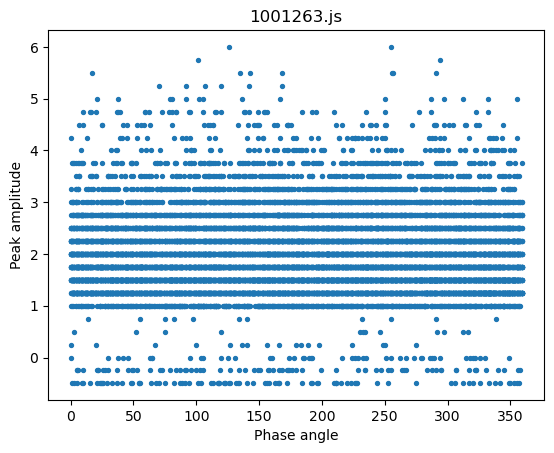

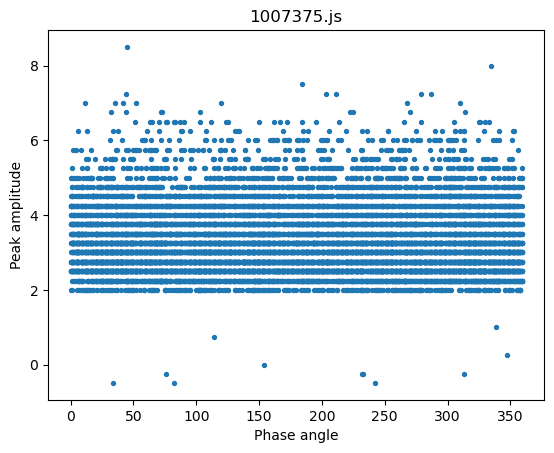

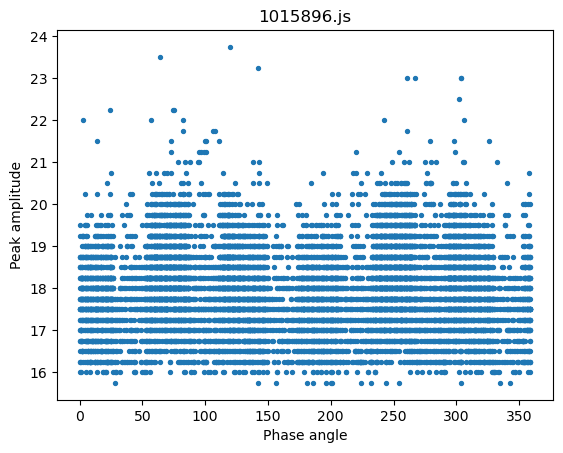

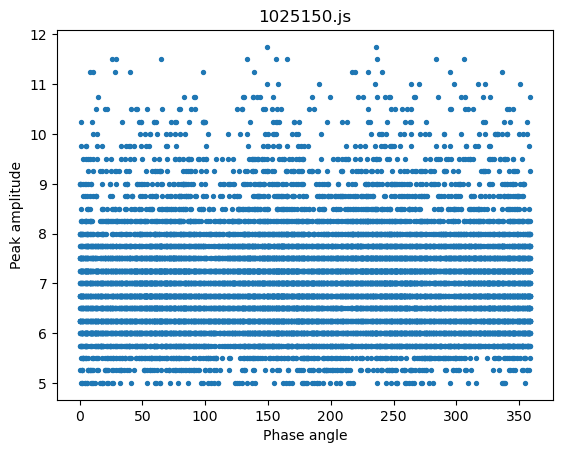

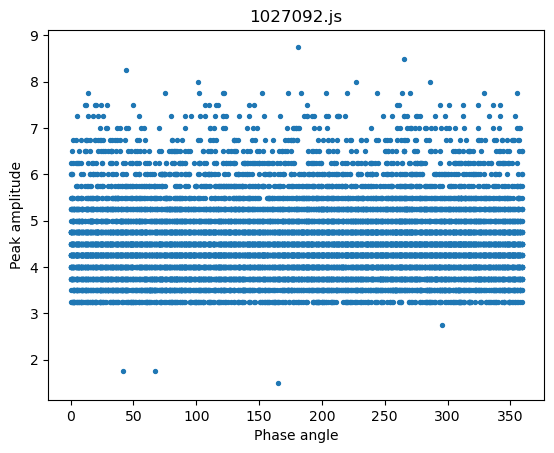

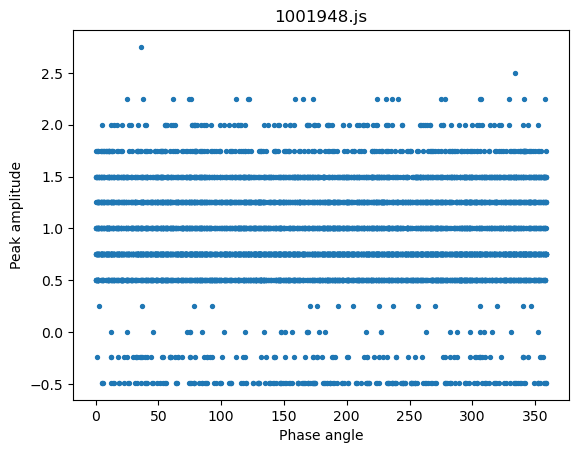

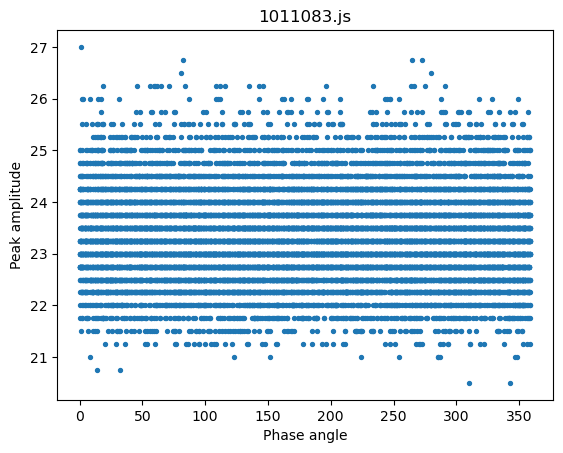

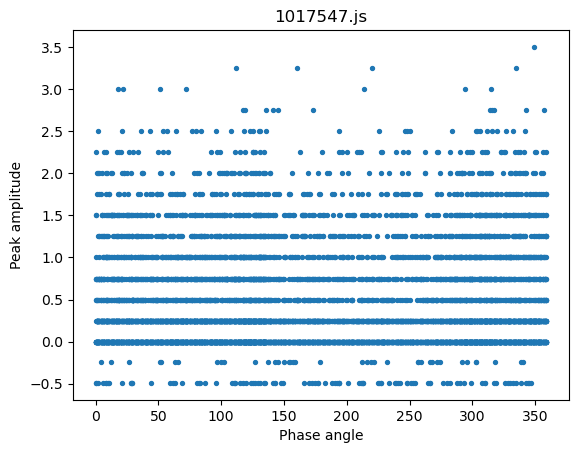

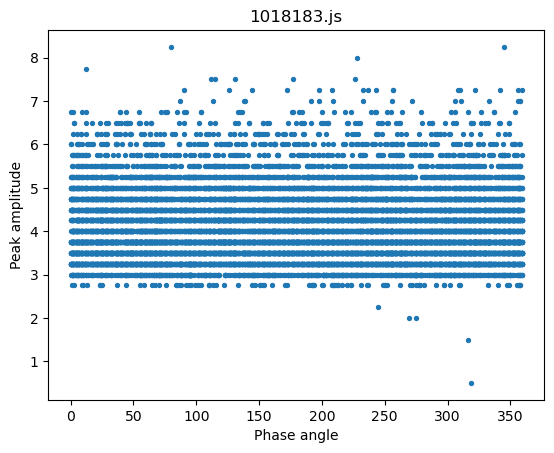

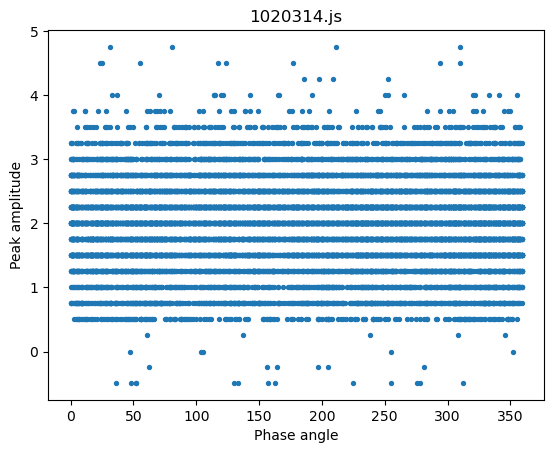

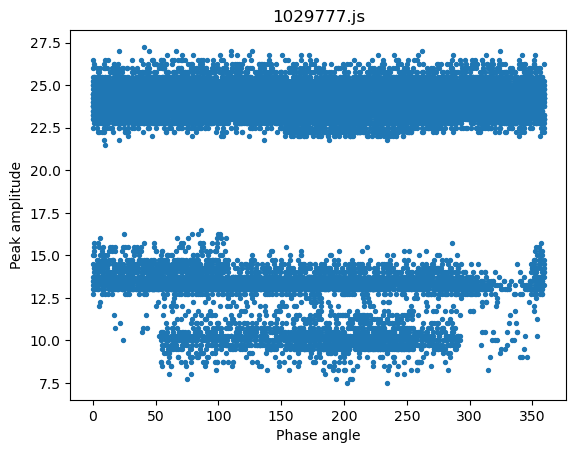

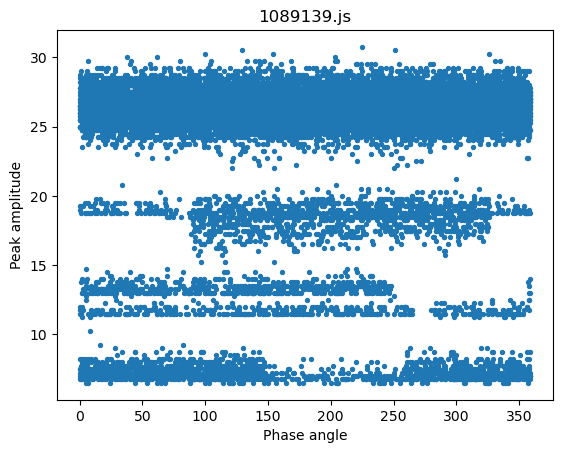

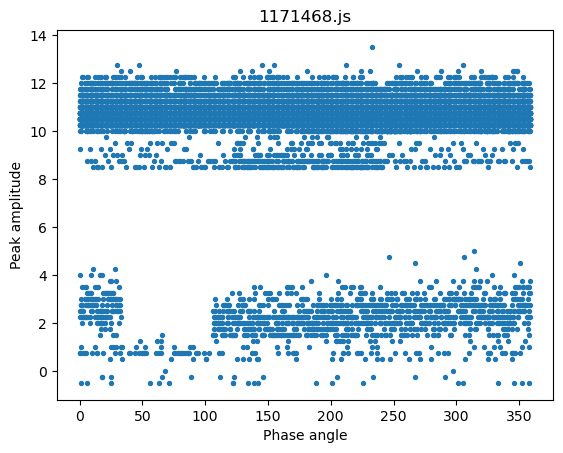

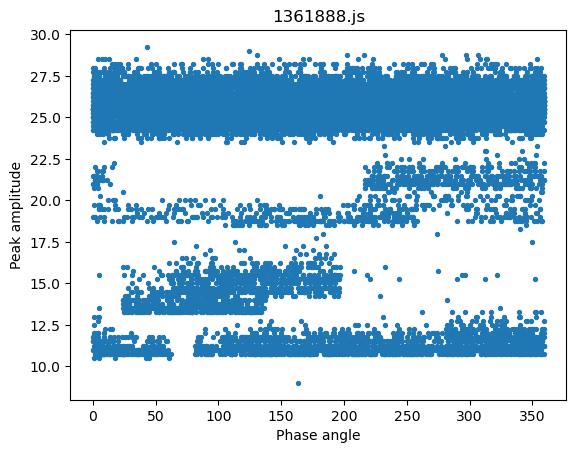

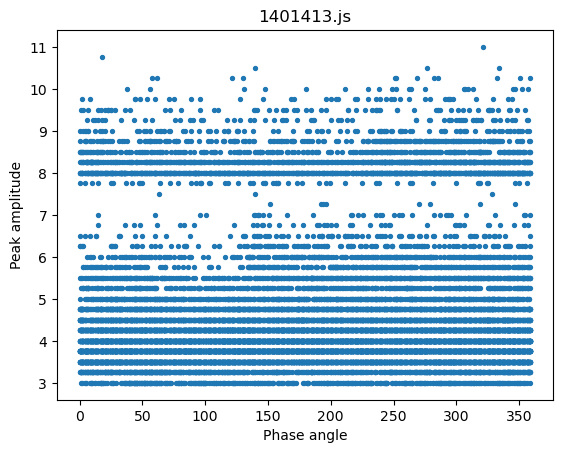

In [93]:
for dataframe in dataframes: # show data into plots
    plt.scatter(dataframe['phase_angle'], dataframe['peak_amplitude'], s=8)
    plt.title(dataframe['filename'].iloc[0])
    plt.xlabel('Phase angle')
    plt.ylabel('Peak amplitude')
    plt.show()

In [94]:
print(dataframes[1])


       peak_amplitude  integral  phase_angle  cycle_number  rise_time  \
0                7.00     -1587          120         12836          0   
1                6.50      1335          124         12836          0   
2                6.50      4182          125         12836          0   
3                6.00      9137          127         12836          0   
4                7.25     -1743          203         12836          0   
...               ...       ...          ...           ...        ...   
14394            3.25      2360          102         13311          0   
14395            2.50      1800          103         13311          0   
14396            2.50      2296          104         13311          0   
14397            2.75      1094          104         13311          0   
14398            3.25      2891          104         13311          1   

       pulse_width    filename  anomaly  
0                0  1007375.js        1  
1                0  1007375.js        1

In [95]:
unique_files = set()

for df in dataframes:
    unique_files = unique_files.union(set(df['filename'].unique()))

print(unique_files)

{'1007375.js', '1401413.js', '1020314.js', '1027092.js', '1018183.js', '1171468.js', '1017547.js', '1015896.js', '1011083.js', '1089139.js', '1025150.js', '1361888.js', '1001263.js', '1029777.js', '1001948.js'}


In [96]:
print(dataframes[1])

       peak_amplitude  integral  phase_angle  cycle_number  rise_time  \
0                7.00     -1587          120         12836          0   
1                6.50      1335          124         12836          0   
2                6.50      4182          125         12836          0   
3                6.00      9137          127         12836          0   
4                7.25     -1743          203         12836          0   
...               ...       ...          ...           ...        ...   
14394            3.25      2360          102         13311          0   
14395            2.50      1800          103         13311          0   
14396            2.50      2296          104         13311          0   
14397            2.75      1094          104         13311          0   
14398            3.25      2891          104         13311          1   

       pulse_width    filename  anomaly  
0                0  1007375.js        1  
1                0  1007375.js        1

In [97]:
def determine_baseline(bucket_data, kmeans, predicted_clusters, threshold=5):
    centroids = kmeans.cluster_centers_
    centroid_distance = abs(centroids[1] - centroids[0])

    if centroid_distance > threshold:
        # Clusters far apart - Outcome 1
        lower_centroid_index = np.argmin(centroids)
        lower_cluster = bucket_data[predicted_clusters == lower_centroid_index]
        return max(lower_cluster['peak_amplitude'])
    else:
        # Clusters close together - Outcome 2
        higher_centroid_index = np.argmax(centroids)
        return centroids[higher_centroid_index][0]

In [98]:
def denoise_dataframes(dataframes):
    warnings.filterwarnings('ignore')
    for df in dataframes:
        # Bucket phase angles
        df['bucket'] = pd.cut(df['phase_angle'], bins=range(0, 361, 10), labels=False)

        # Perform k-means clustering on each bucket and determine baselines
        kmeans_results = []
        bucket_baselines = []
        for i in range(36):
            bucket_data = df[df['bucket'] == i]
            if not bucket_data.empty and len(bucket_data) > 1:
                kmeans = KMeans(n_clusters=2, random_state=0, n_init=10)
                kmeans.fit(bucket_data['peak_amplitude'].values.reshape(-1, 1))
                kmeans_results.append((i, kmeans))

                # Predict the clusters for bucket_data
                predicted_clusters = kmeans.predict(bucket_data['peak_amplitude'].values.reshape(-1, 1))

                # Pass the predicted clusters to the determine_baseline function
                baseline = determine_baseline(bucket_data, kmeans, predicted_clusters)
                bucket_baselines.append((i, baseline))
            else:
                kmeans_results.append((i, None))
                bucket_baselines.append((i, None))

        # Assign cluster labels to each data point
        df['cluster'] = np.nan
        for i, kmeans in kmeans_results:
            if kmeans is not None:
                mask = df['bucket'] == i
                df.loc[mask, 'cluster'] = kmeans.predict(df.loc[mask, 'peak_amplitude'].values.reshape(-1, 1))

        baselines = [baseline for _, baseline in bucket_baselines if baseline is not None]
        basemode = mode(baselines).mode[0]

        # Remove points below the baseline mode (inserted)
        df.loc[:, 'filtered'] = df['peak_amplitude'] >= basemode

        # Scatter plot with bucketed phase angles and clustered data points
        plt.scatter(df['phase_angle'], df['peak_amplitude'], c=df['cluster'], cmap='viridis', s=8)
        plt.title(df['filename'].iloc[0])
        plt.xlabel('Phase angle')
        plt.ylabel('Peak amplitude')

        # Plot baselines
        for i, baseline in bucket_baselines:
            if baseline is not None:
                plt.hlines(baseline, i * 10, (i + 1) * 10 - 1, colors='r', linestyles='dashed')
        plt.hlines(basemode, 0, 359, colors='b', linestyles='solid')
        plt.show()

    return dataframes

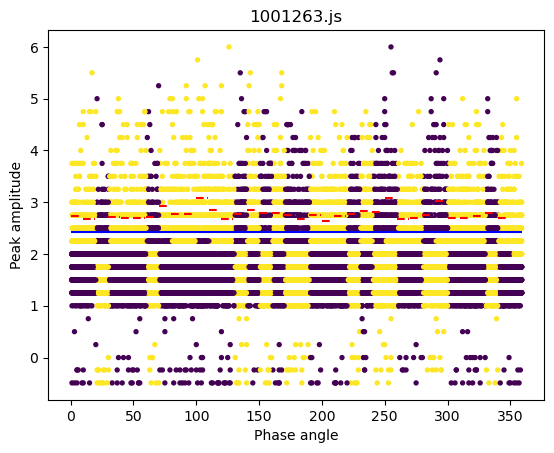

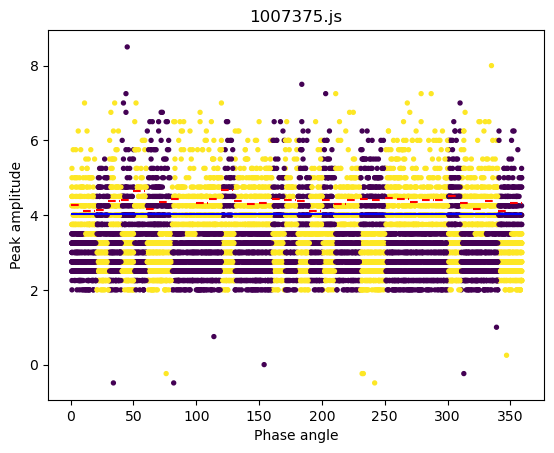

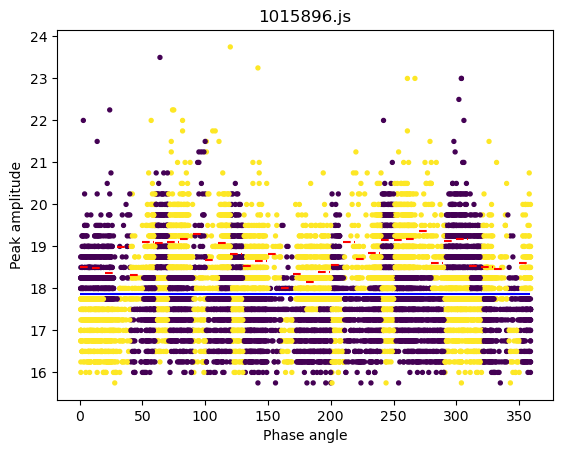

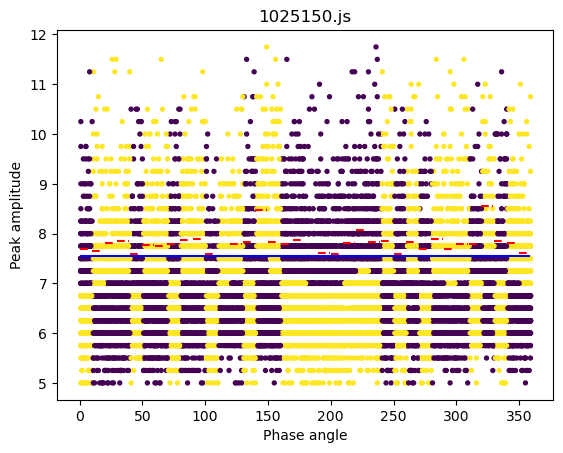

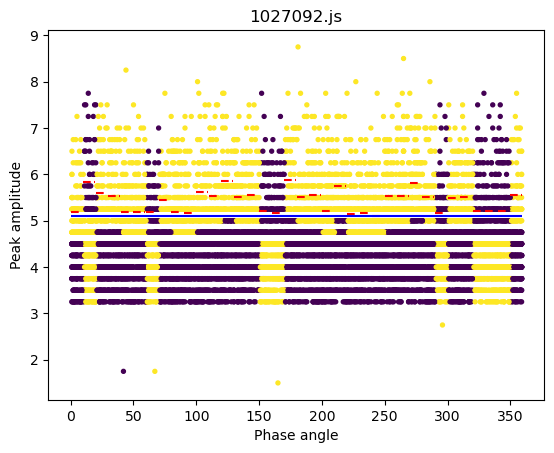

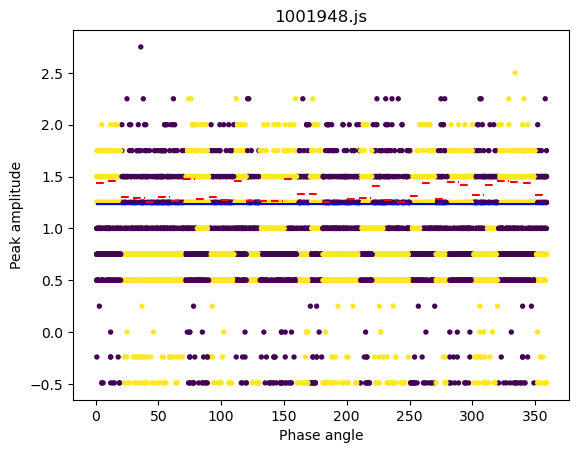

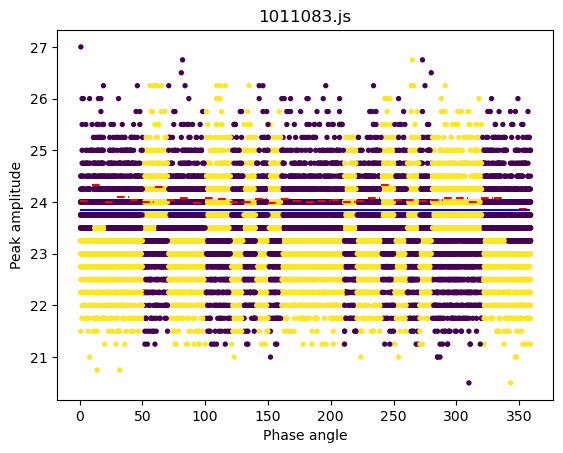

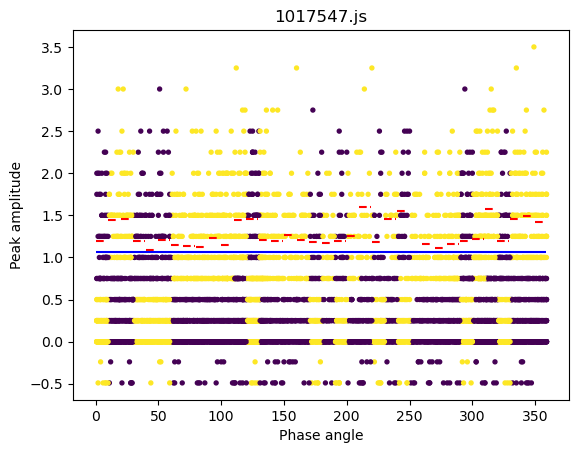

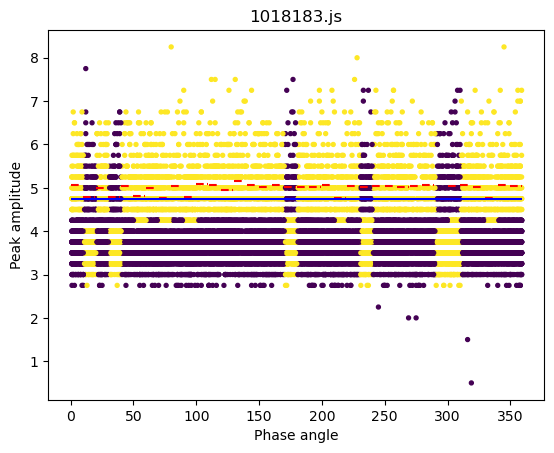

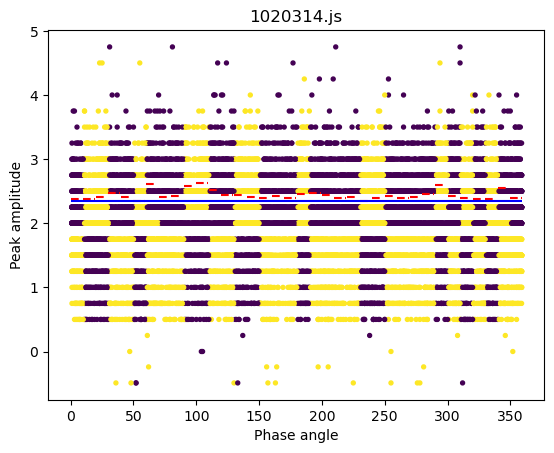

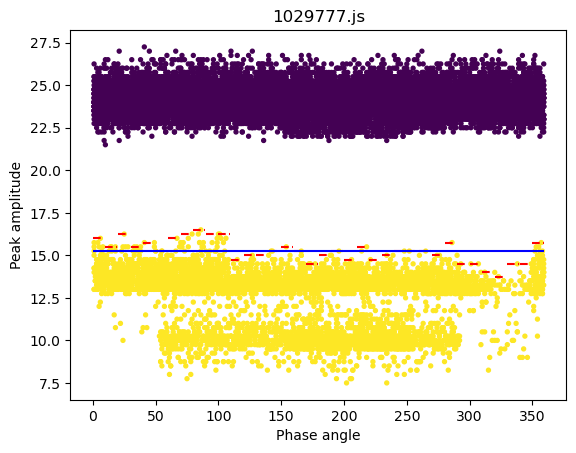

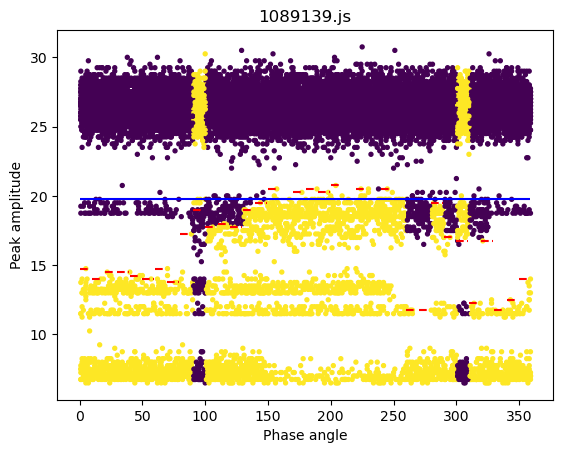

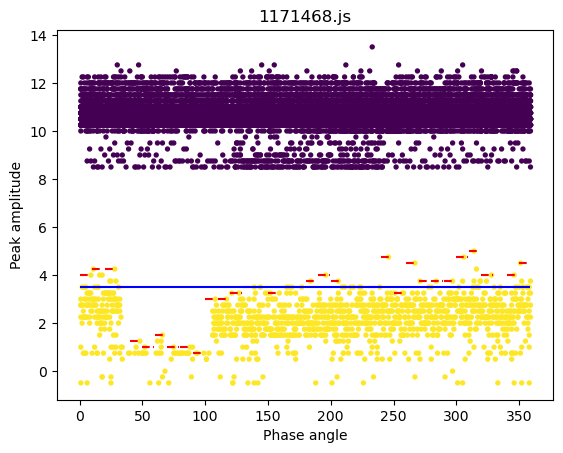

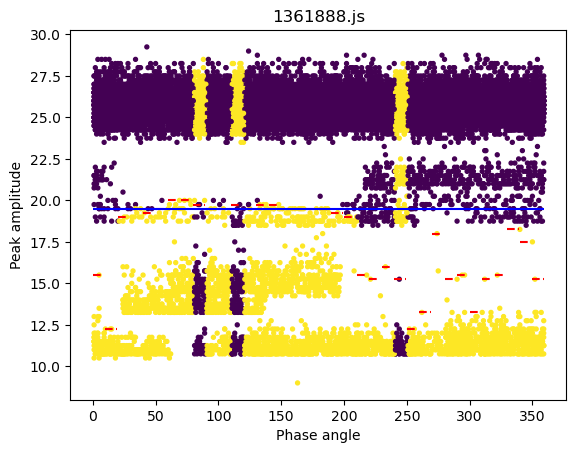

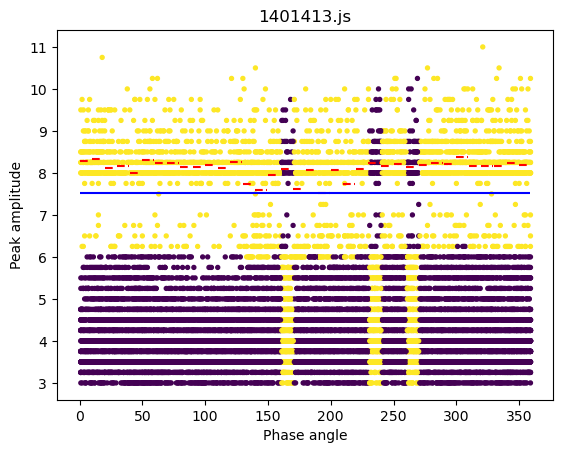

In [99]:
dataframes = denoise_dataframes(dataframes)

In [100]:
print(dataframes[1])

       peak_amplitude  integral  phase_angle  cycle_number  rise_time  \
0                7.00     -1587          120         12836          0   
1                6.50      1335          124         12836          0   
2                6.50      4182          125         12836          0   
3                6.00      9137          127         12836          0   
4                7.25     -1743          203         12836          0   
...               ...       ...          ...           ...        ...   
14394            3.25      2360          102         13311          0   
14395            2.50      1800          103         13311          0   
14396            2.50      2296          104         13311          0   
14397            2.75      1094          104         13311          0   
14398            3.25      2891          104         13311          1   

       pulse_width    filename  anomaly  bucket  cluster  filtered  
0                0  1007375.js        1    11.0      1

In [101]:
filtered_dataframes = [df[df['filtered'] == True] for df in dataframes]

In [102]:
print(filtered_dataframes[1])

       peak_amplitude  integral  phase_angle  cycle_number  rise_time  \
0                7.00     -1587          120         12836          0   
1                6.50      1335          124         12836          0   
2                6.50      4182          125         12836          0   
3                6.00      9137          127         12836          0   
4                7.25     -1743          203         12836          0   
...               ...       ...          ...           ...        ...   
14340            4.75      1874           22         13311         97   
14355            4.50      4487           65         13311          0   
14368            4.25     -2936           69         13311          0   
14385            5.00      1555           79         13311          0   
14393            4.25      2250          102         13311          0   

       pulse_width    filename  anomaly  bucket  cluster  filtered  
0                0  1007375.js        1    11.0      1

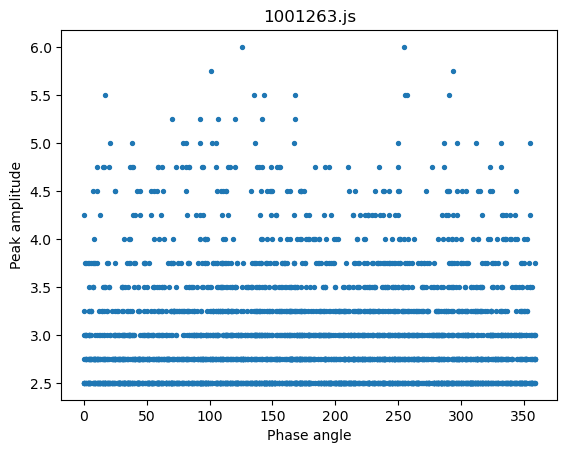

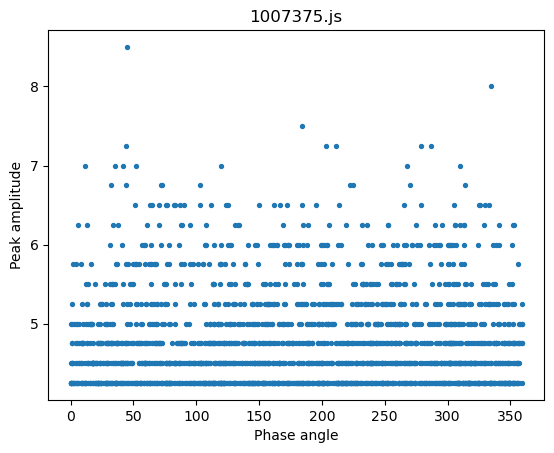

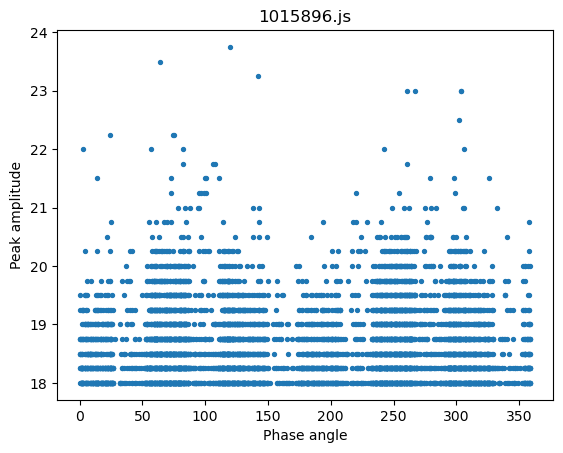

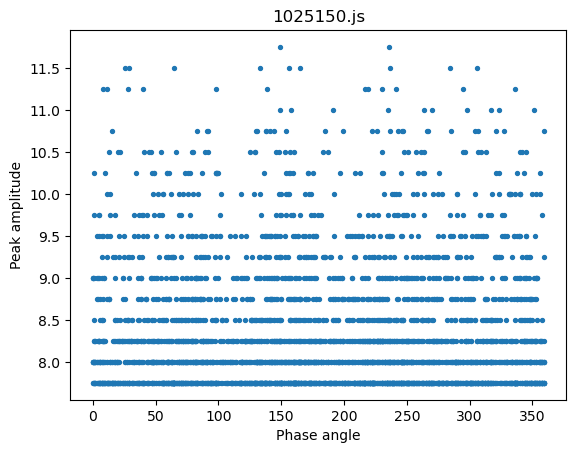

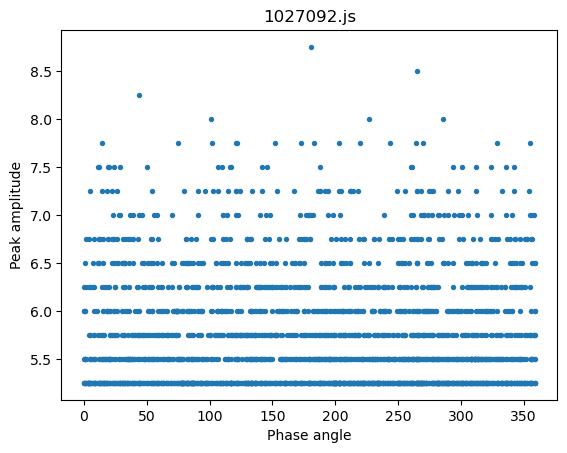

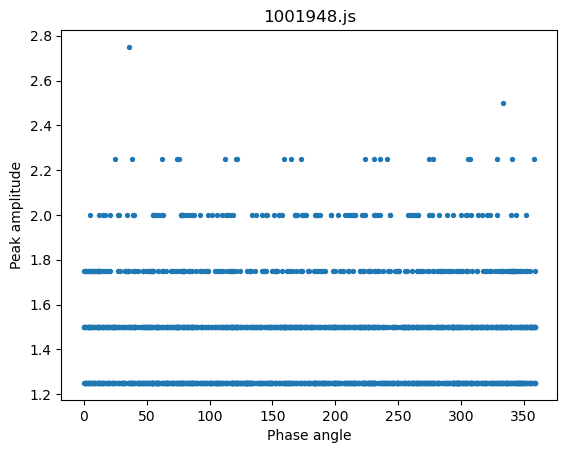

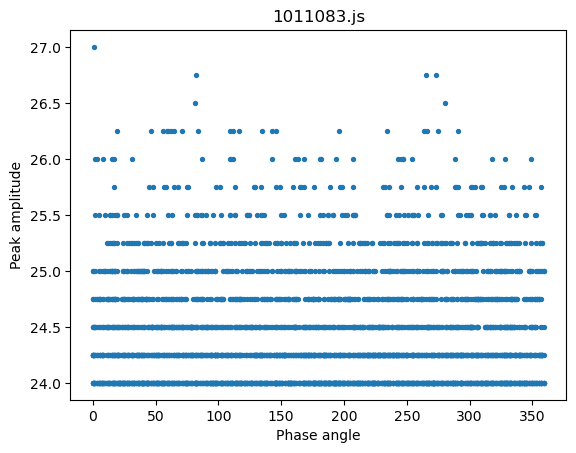

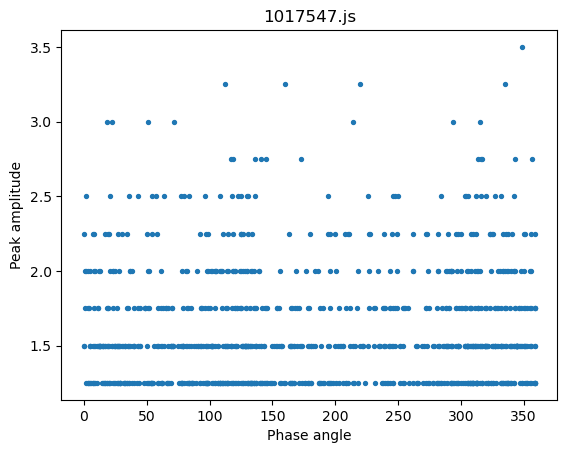

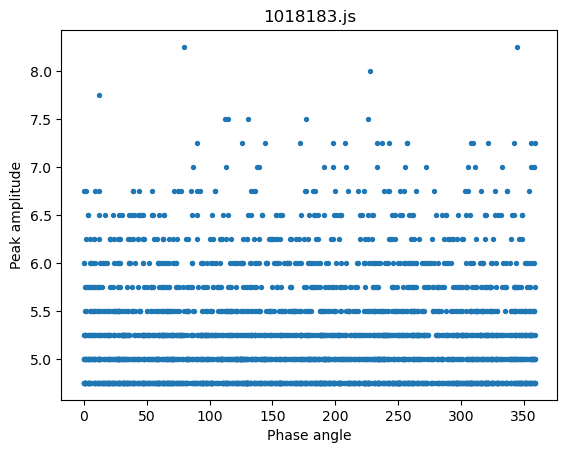

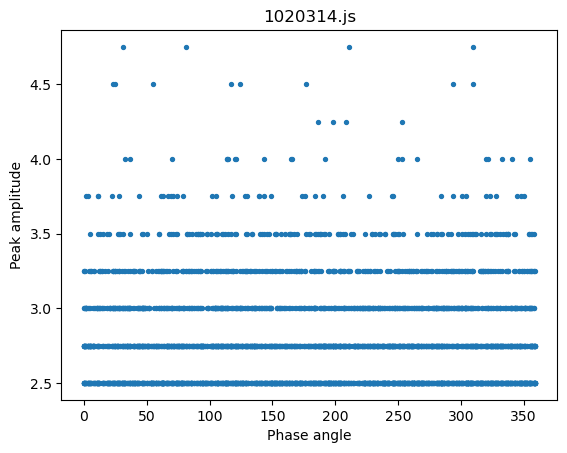

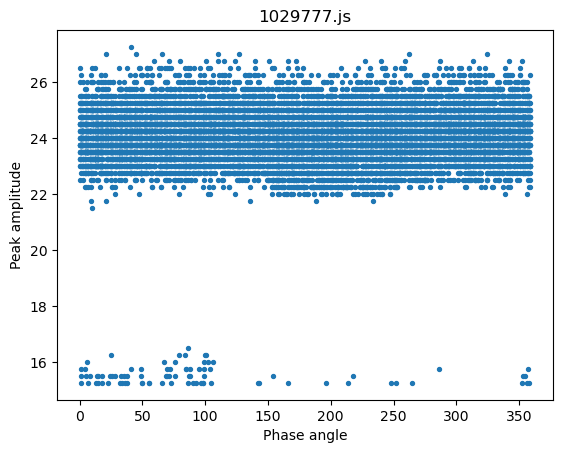

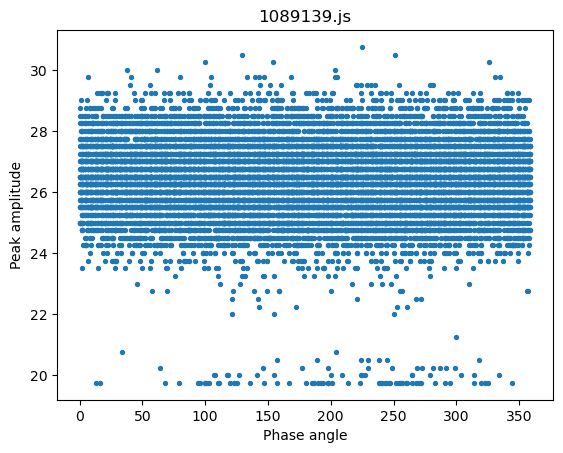

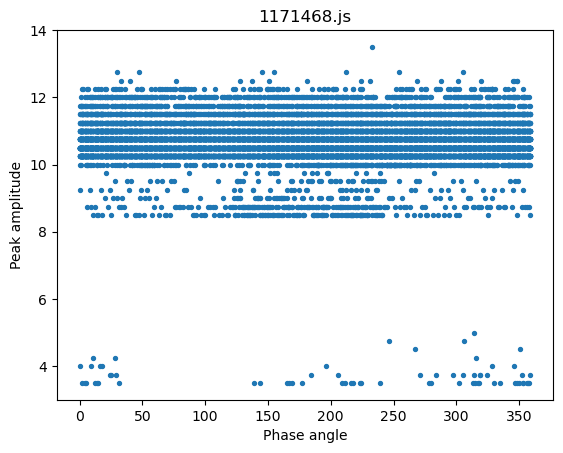

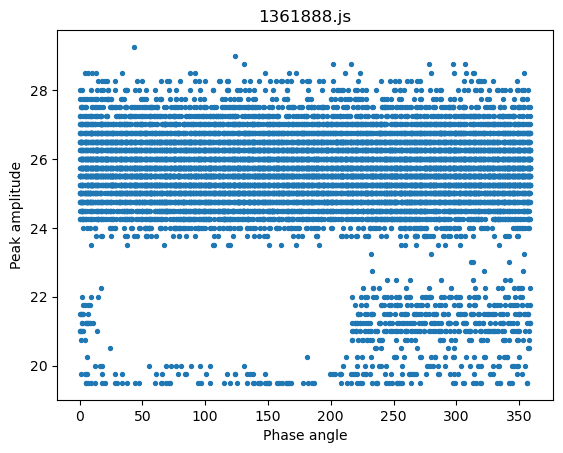

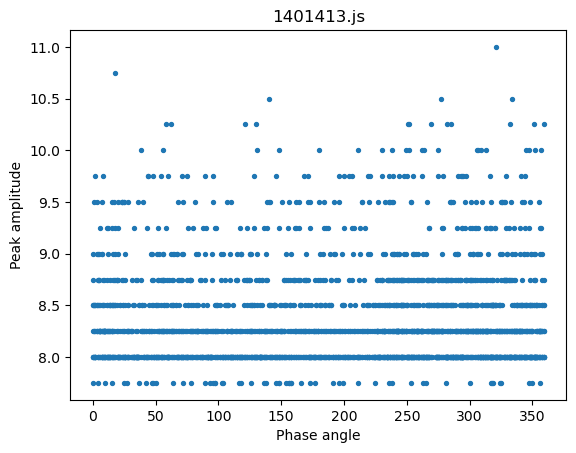

In [103]:
for dataframe in filtered_dataframes: #show new graphs with threshold removed
    fig, ax = plt.subplots()
    ax.scatter(dataframe['phase_angle'], dataframe['peak_amplitude'], s=8)
    ax.set_title(dataframe['filename'].iloc[0])
    ax.set_xlabel('Phase angle')
    ax.set_ylabel('Peak amplitude')


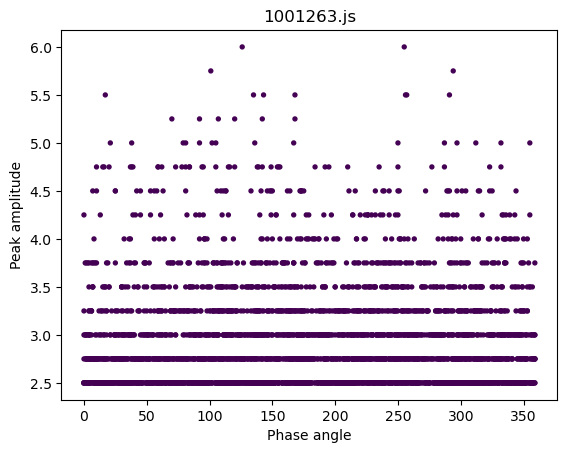

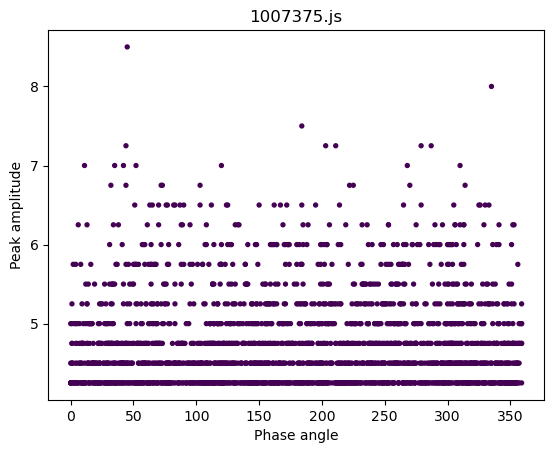

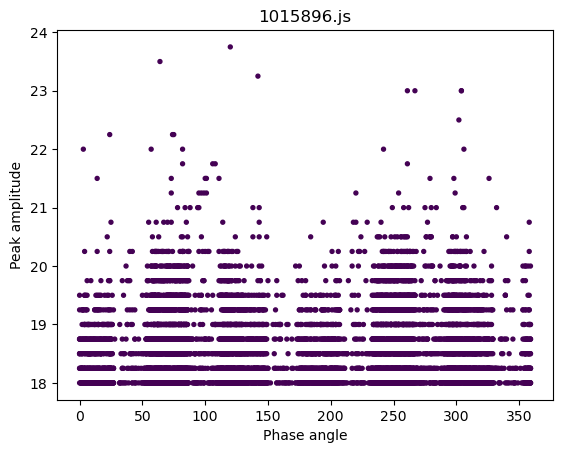

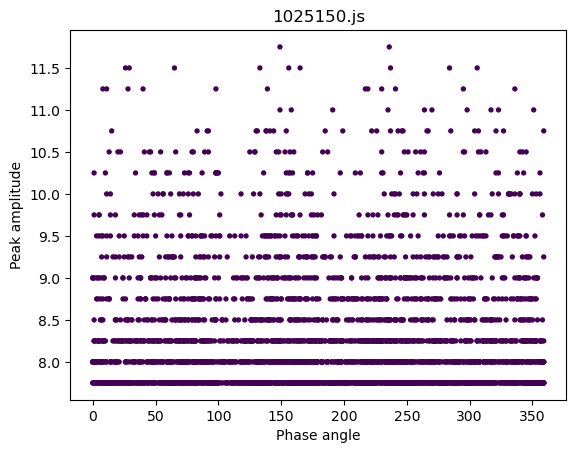

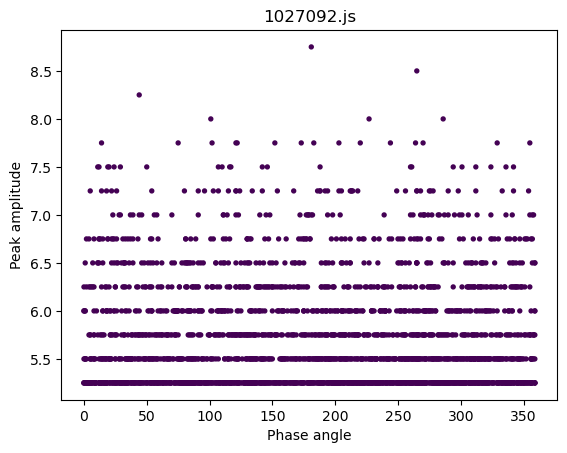

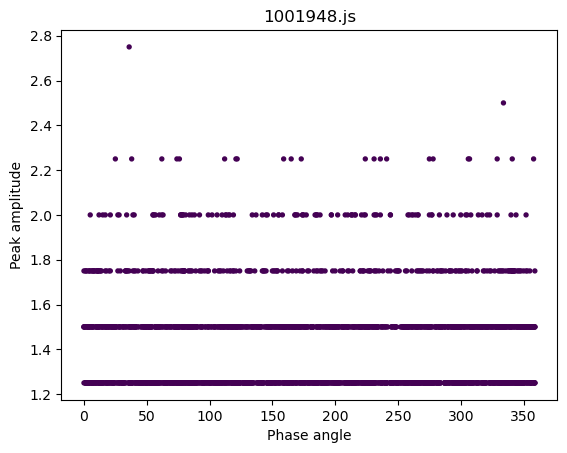

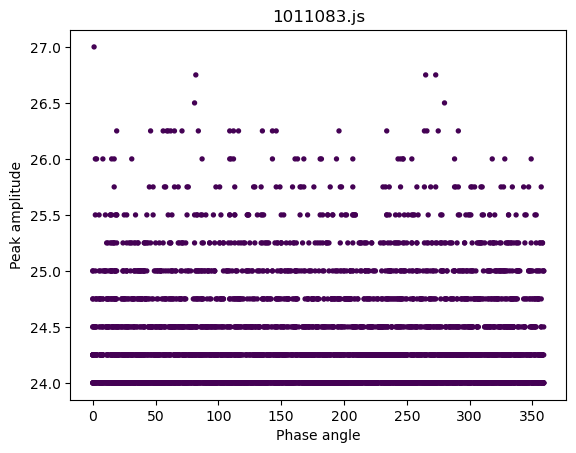

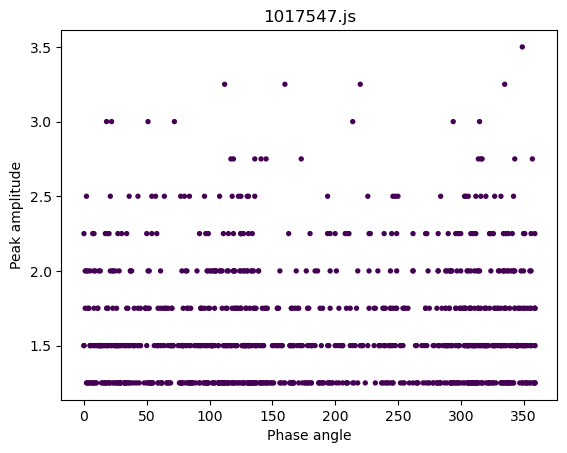

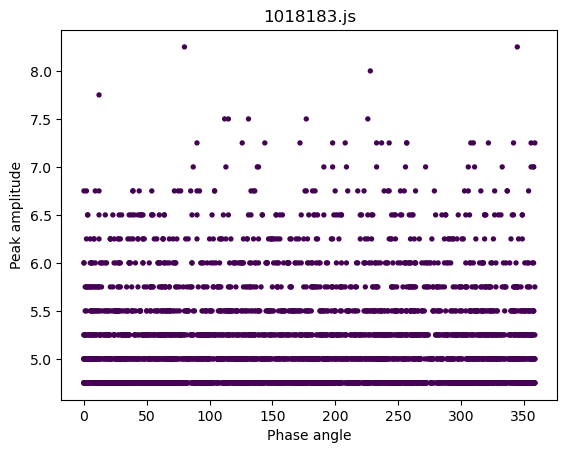

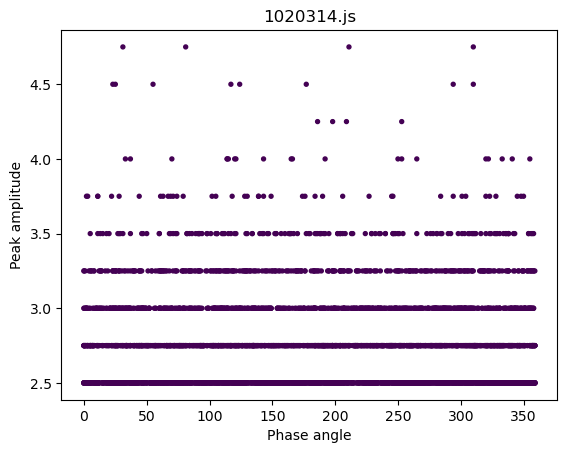

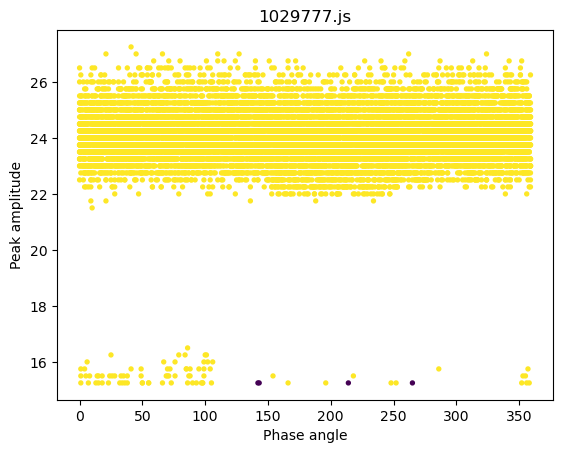

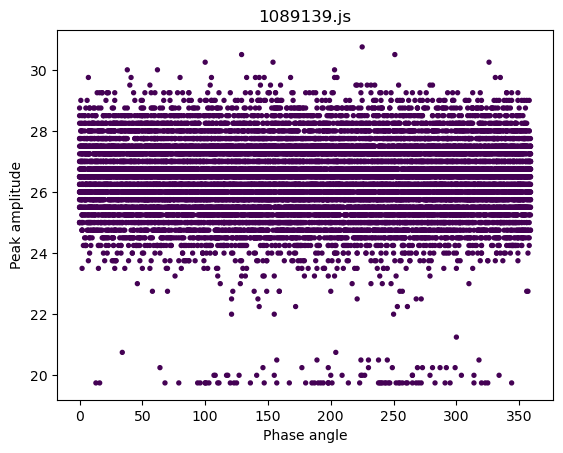

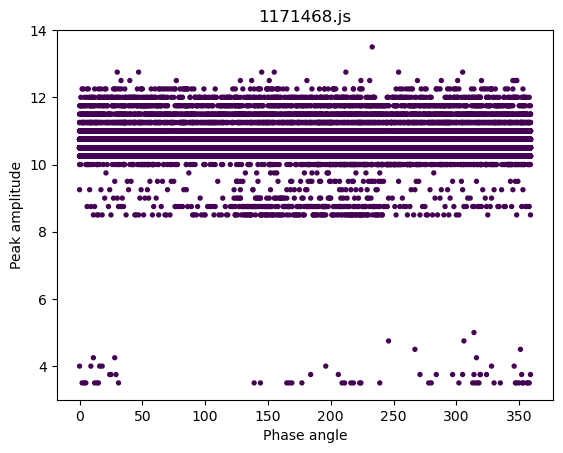

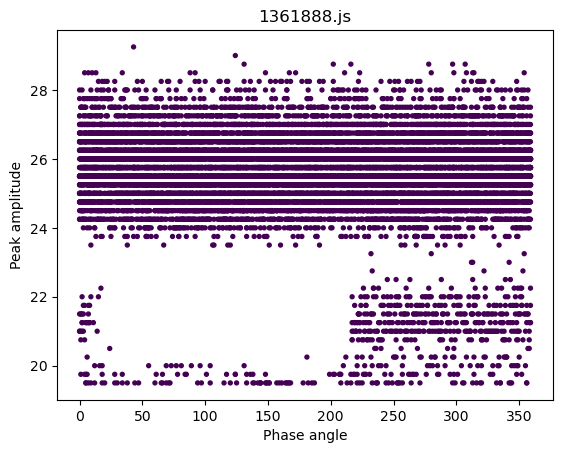

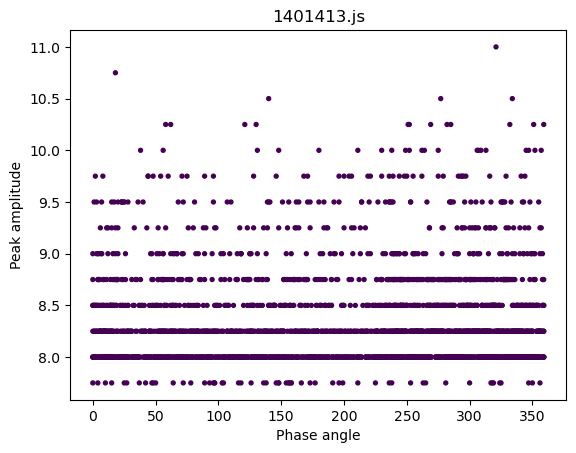

In [104]:
# Initialize lists for the cluster features
for df in filtered_dataframes:
    # Extract the relevant columns
    X = df[['phase_angle', 'peak_amplitude']].values
    
    # Apply DBSCAN to the data
    dbscan = DBSCAN(eps=7, min_samples=8)
    dbscan.fit(X)
    labels = dbscan.labels_
    
    # Create a copy of the dataframe to avoid SettingWithCopyWarning
    df_copy = df.copy()
    
    # Add the cluster labels to the dataframe copy
    df_copy['cluster'] = labels
    
    # Access cluster information
    clusters = set(labels)
    for cluster in clusters:
        if cluster != -1:
            # Get the points belonging to the cluster
            cluster_points = X[labels == cluster]
            
            # Calculate cluster features
            cluster_length = cluster_points[:, 0].max() - cluster_points[:, 0].min()
            cluster_height = cluster_points[:, 1].max() - cluster_points[:, 1].min()
            cluster_gradient_tr = (cluster_points[:, 1].max() - cluster_points[:, 1].min()) / (cluster_points[:, 0].max() - cluster_points[:, 0].min())
            cluster_gradient_tl = (cluster_points[:, 1].max() - cluster_points[:, 1].min()) / (cluster_points[:, 0].min() - cluster_points[:, 0].max())
            
            # Add new columns for cluster features to the dataframe copy
            df_copy.loc[labels == cluster, 'cluster_length'] = cluster_length
            df_copy.loc[labels == cluster, 'cluster_height'] = cluster_height
            df_copy.loc[labels == cluster, 'cluster_gradient_tr'] = cluster_gradient_tr
            df_copy.loc[labels == cluster, 'cluster_gradient_tl'] = cluster_gradient_tl
    
    # Assign the cluster labels and features to the original dataframe
    df.loc[:, 'cluster'] = df_copy['cluster']
    df.loc[:, 'cluster_length'] = df_copy['cluster_length']
    df.loc[:, 'cluster_height'] = df_copy['cluster_height']
    df.loc[:, 'cluster_gradient_tr'] = df_copy['cluster_gradient_tr']
    df.loc[:, 'cluster_gradient_tl'] = df_copy['cluster_gradient_tl']
    
    # Plot the clustered data
    plt.scatter(df['phase_angle'], df['peak_amplitude'], c=df['cluster'], cmap='viridis', s=8)
    plt.title(df['filename'].iloc[0])
    plt.xlabel('Phase angle')
    plt.ylabel('Peak amplitude')
    plt.show()


Cluster 0: Length=359.0, Height=3.5, GradientTR=0.009749303621169917, GradientTL=-0.009749303621169917


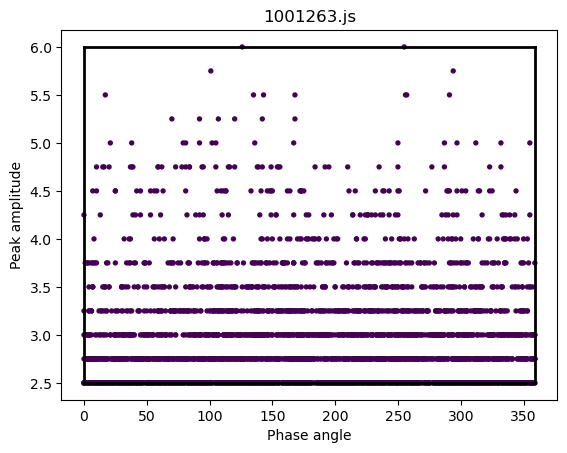

Cluster 0: Length=359.0, Height=4.25, GradientTR=0.011838440111420613, GradientTL=-0.011838440111420613


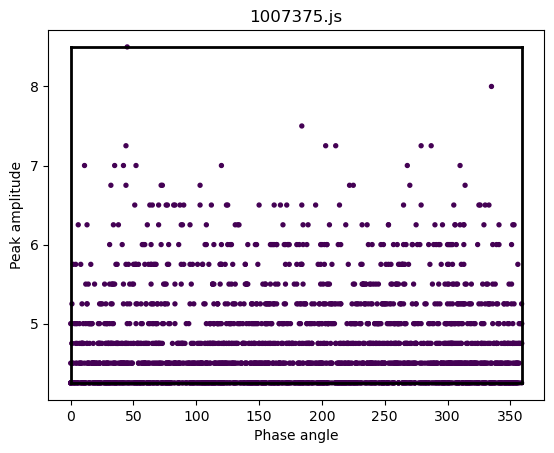

Cluster 0: Length=359.0, Height=5.75, GradientTR=0.016016713091922007, GradientTL=-0.016016713091922007


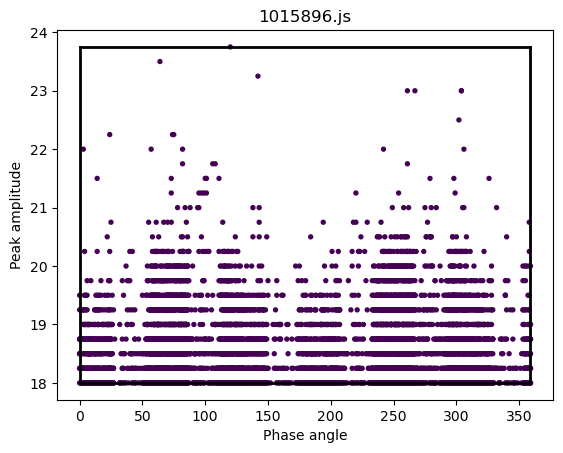

Cluster 0: Length=359.0, Height=4.0, GradientTR=0.011142061281337047, GradientTL=-0.011142061281337047


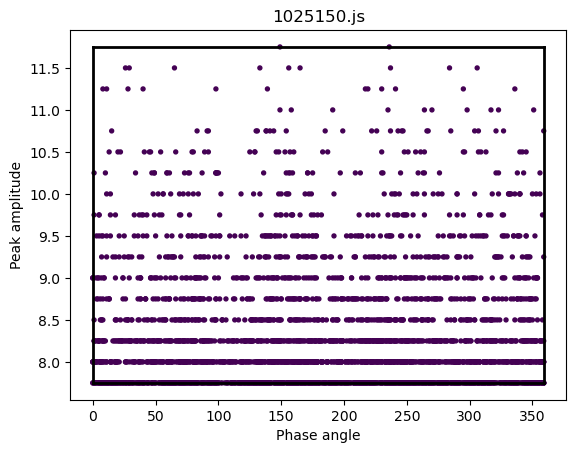

Cluster 0: Length=359.0, Height=3.5, GradientTR=0.009749303621169917, GradientTL=-0.009749303621169917


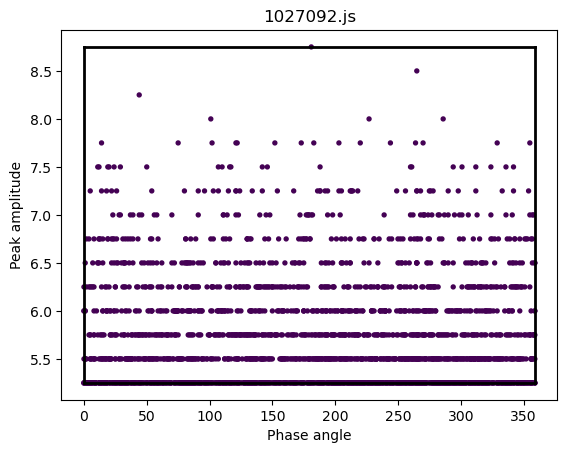

Cluster 0: Length=359.0, Height=1.5, GradientTR=0.004178272980501393, GradientTL=-0.004178272980501393


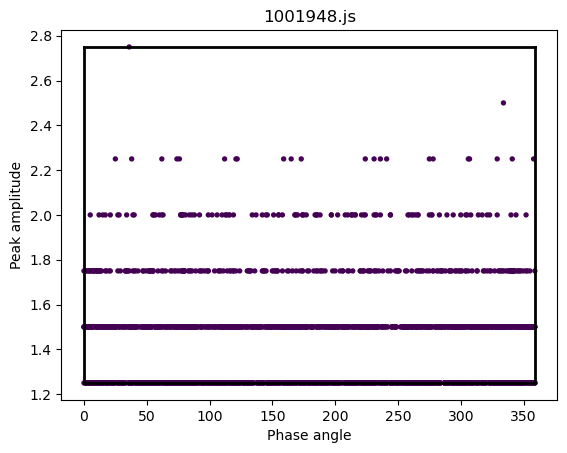

Cluster 0: Length=359.0, Height=3.0, GradientTR=0.008356545961002786, GradientTL=-0.008356545961002786


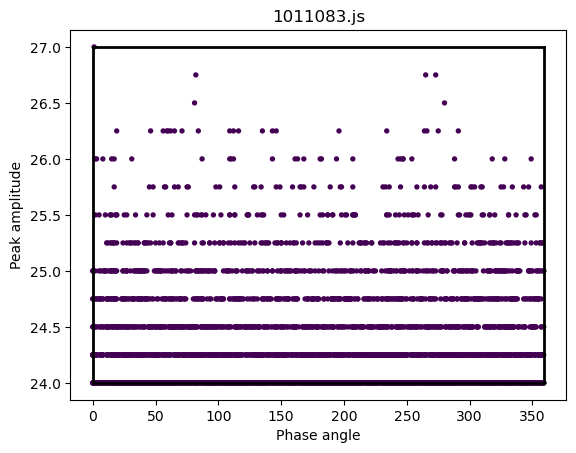

Cluster 0: Length=359.0, Height=2.25, GradientTR=0.006267409470752089, GradientTL=-0.006267409470752089


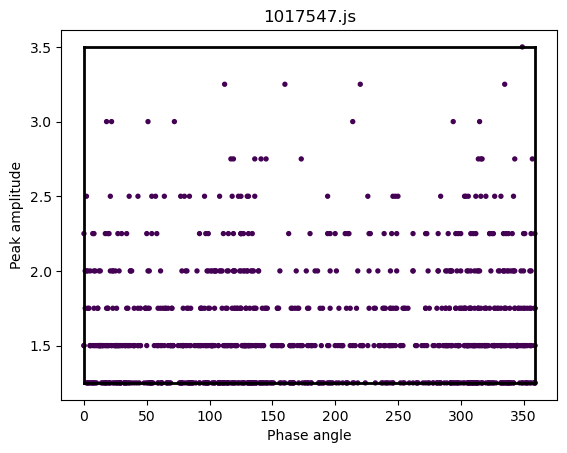

Cluster 0: Length=359.0, Height=3.5, GradientTR=0.009749303621169917, GradientTL=-0.009749303621169917


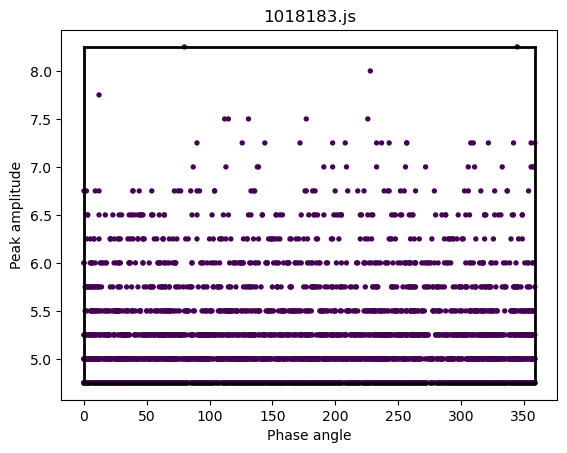

Cluster 0: Length=359.0, Height=2.25, GradientTR=0.006267409470752089, GradientTL=-0.006267409470752089


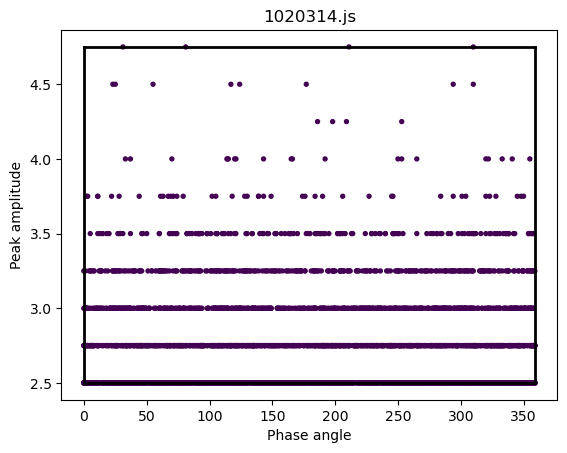

Cluster 0: Length=359.0, Height=12.0, GradientTR=0.033426183844011144, GradientTL=-0.033426183844011144


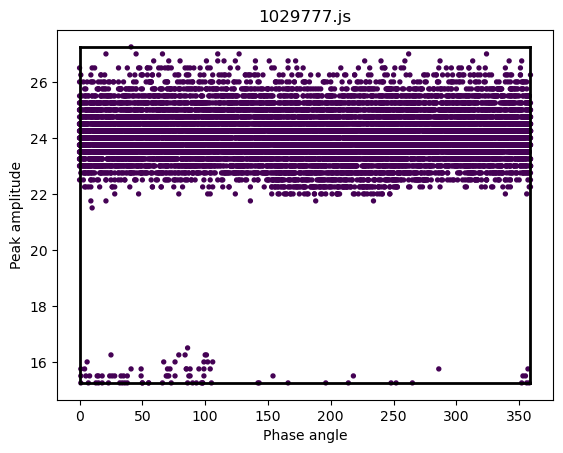

Cluster 0: Length=359.0, Height=11.0, GradientTR=0.03064066852367688, GradientTL=-0.03064066852367688


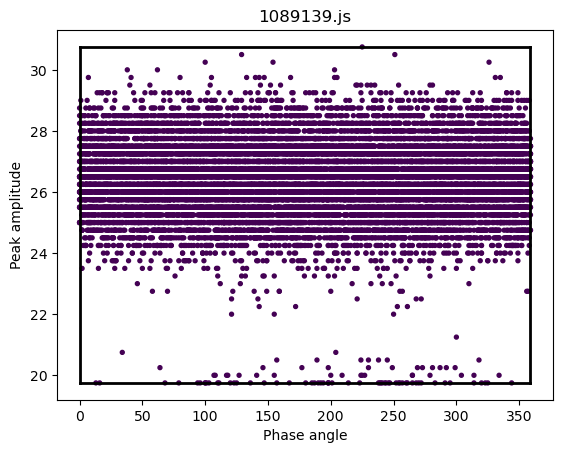

Cluster 0: Length=359.0, Height=10.0, GradientTR=0.027855153203342618, GradientTL=-0.027855153203342618


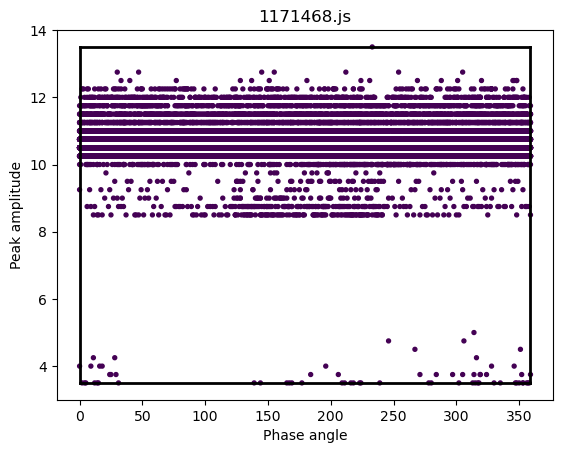

Cluster 0: Length=359.0, Height=9.75, GradientTR=0.027158774373259052, GradientTL=-0.027158774373259052


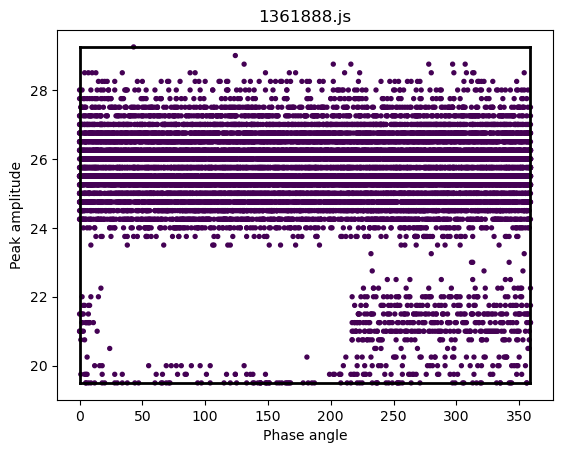

Cluster 0: Length=359.0, Height=3.25, GradientTR=0.009052924791086351, GradientTL=-0.009052924791086351


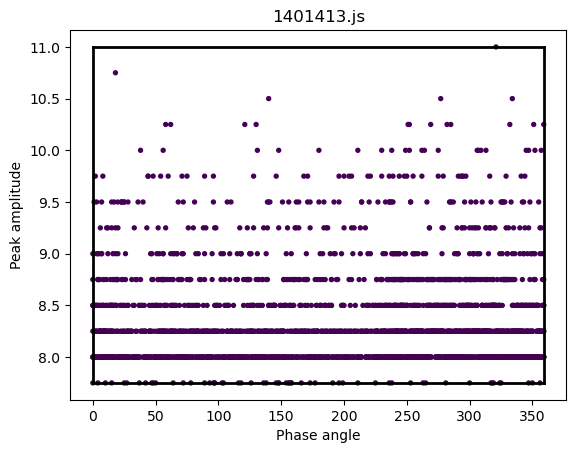

In [105]:
def plot_cluster_bounds(cluster_points):
    x_min, x_max = cluster_points[:, 0].min(), cluster_points[:, 0].max()
    y_min, y_max = cluster_points[:, 1].min(), cluster_points[:, 1].max()
    plt.plot([x_min, x_max], [y_min, y_min], 'k-', linewidth=2)
    plt.plot([x_max, x_max], [y_min, y_max], 'k-', linewidth=2)
    plt.plot([x_max, x_min], [y_max, y_max], 'k-', linewidth=2)
    plt.plot([x_min, x_min], [y_max, y_min], 'k-', linewidth=2)


for df in filtered_dataframes:
    # Extract the relevant columns
    X = df[['phase_angle', 'peak_amplitude']].values
    
    # Apply DBSCAN to the data
    dbscan = DBSCAN(eps=10, min_samples=10)
    dbscan.fit(X)
    labels = dbscan.labels_
    
    # Add the cluster labels to the dataframe
    df['cluster'] = labels
    
    # Create new columns for each cluster label
    dummies = pd.get_dummies(df['cluster'], prefix='cluster')
    df = pd.concat([df, dummies], axis=1)
    
    # Access cluster information
    clusters = set(labels)
    for cluster in clusters:
        if cluster != -1:
            # Get the points belonging to the cluster
            cluster_points = X[labels == cluster]
            
            # Calculate cluster features
            cluster_length = cluster_points[:, 0].max() - cluster_points[:, 0].min()
            cluster_height = cluster_points[:, 1].max() - cluster_points[:, 1].min()
            cluster_gradient_tr = (cluster_points[:, 1].max() - cluster_points[:, 1].min()) / (cluster_points[:, 0].max() - cluster_points[:, 0].min())
            cluster_gradient_tl = (cluster_points[:, 1].max() - cluster_points[:, 1].min()) / (cluster_points[:, 0].min() - cluster_points[:, 0].max())
            
            # Print cluster information
            print(f"Cluster {cluster}: Length={cluster_length}, Height={cluster_height}, GradientTR={cluster_gradient_tr}, GradientTL={cluster_gradient_tl}")
            
            # Plot the boundaries of the cluster
            plot_cluster_bounds(cluster_points)
    
    # Plot the clustered data
    plt.scatter(df['phase_angle'], df['peak_amplitude'], c=df['cluster'], cmap='viridis', s=8)
    plt.title(df['filename'].iloc[0])
    plt.xlabel('Phase angle')
    plt.ylabel('Peak amplitude')
    plt.show()


In [106]:
# drop useless columns
for df in filtered_dataframes:
    df.drop(["integral", "cycle_number", "filtered", "bucket", "filename"], axis=1, inplace=True)

In [107]:
print(filtered_dataframes[0]) # integers in this column indicate the cluster that they belong to, if its a -1 it means that it is an outlier and is not included in any clusters

       peak_amplitude  phase_angle  rise_time  pulse_width  anomaly  cluster  \
0                4.75           78          0            0        1        0   
1                5.00           79          0            0        1        0   
2                4.75           81          0            0        1        0   
3                4.75           84          0            0        1        0   
4                4.75           84          0            0        1        0   
...               ...          ...        ...          ...      ...      ...   
14676            2.50          315        480          481        1        0   
14682            2.75          320          0           15        1        0   
14684            4.00          322         16           17        1        0   
14686            3.00          323        128          144        1        0   
14689            2.50          326        353          368        1        0   

       cluster_length  cluster_height  

In [109]:
# convert list of dataframes into 1 big dataframe
big_df = pd.concat(filtered_dataframes, ignore_index=True)

In [113]:
big_df.isna().sum()
# missing = big_df.isna().any(axis=1)
# print(df[missing])

peak_amplitude         0
phase_angle            0
rise_time              0
pulse_width            0
anomaly                0
cluster                0
cluster_length         4
cluster_height         4
cluster_gradient_tr    4
cluster_gradient_tl    4
dtype: int64

In [114]:
big_df.fillna(0, inplace=True)


In [115]:
big_df.isna().sum()

peak_amplitude         0
phase_angle            0
rise_time              0
pulse_width            0
anomaly                0
cluster                0
cluster_length         0
cluster_height         0
cluster_gradient_tr    0
cluster_gradient_tl    0
dtype: int64

In [117]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
# Split the data into training and testing sets
train_dfs, test_dfs = train_test_split(big_df, test_size=0.2, random_state=42)

# Define the features and target variables
features = ['peak_amplitude', 'phase_angle', 'rise_time', 'pulse_width', 'anomaly', 'cluster', 'cluster_length', 'cluster_height', 'cluster_gradient_tr', 'cluster_gradient_tl']
target = 'anomaly' # Replace this with the name of the target column you want to predict

# Split the data into features and target
X = big_df[features]
y = big_df[target]

# Train the decision tree model with 5-fold cross-validation
model = DecisionTreeClassifier(random_state=42)
scores = cross_val_score(model, X, y, cv=5)

# Train the decision tree model
model = DecisionTreeClassifier(random_state=42)
model.fit(train_dfs[features], train_dfs[target])

# Make predictions on the testing set
predictions = model.predict(test_dfs[features])

# Calculate the accuracy of the model
accuracy = accuracy_score(test_dfs[target], predictions)
print(f"Accuracy: {accuracy}")

from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(test_dfs[target], predictions)
print(report)


Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13037
           1       1.00      1.00      1.00      3652
           2       1.00      1.00      1.00      2920

    accuracy                           1.00     19609
   macro avg       1.00      1.00      1.00     19609
weighted avg       1.00      1.00      1.00     19609

